# <font style="color:blue">Project 3: Object Detection</font>


#### Maximum Points: 100

<div>
    <table>
        <tr><td><h6>Sr. no.</h6></td> <td><h6>Section</h6></td> <td><h6>Points</h6></td> </tr>
        <tr><td><h6>1</h6></td> <td><h6>Plot Ground Truth Bounding Boxes</h6></td> <td><h6>20</h6></td> </tr>
        <tr><td><h6>2</h6></td> <td><h6>Training</h6></td> <td><h6>25</h6></td> </tr>
        <tr><td><h6>3</h6></td> <td><h6>Inference</h6></td> <td><h6>15</h6></td> </tr>
        <tr><td><h6>4</h6></td> <td><h6>COCO Detection Evaluation</h6></td> <td><h6>25</h6></td> </tr>
        <tr><td><h6>5</h6></td> <td><h6>Run Inference on a Video</h6></td> <td><h6>15</h6></td> </tr>
    </table>
</div>


In [7]:
# Standard Library imports
from pathlib import Path
import os
import shutil

# External library imports
import torch
import cv2
import numpy as np
from IPython import display
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
from torchvision.io import read_image
from torchvision.utils import draw_bounding_boxes

In [8]:
data_path = Path(r"F:\DATASETS\vehicle-registration-plate-dataset\Dataset")
train_path = data_path / "train" / "Vehicle registration plate"
valid_path = data_path / "validation" / "Vehicle registration plate"

In [ ]:
# !git clone https://github.com/ultralytics/yolov5
# %cd yolov5
# %pip install -qr requirements.txt
# %cd ../

In [69]:
def cv2_imshow(a):
    """A replacement for cv2.imshow() for use in Jupyter notebooks.

    Args:
      a: np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. For
        example, a shape of (N, M, 3) is an NxM BGR color image, and a shape of
        (N, M, 4) is an NxM BGRA color image.
    """
    a = a.clip(0, 255).astype("uint8")
    # cv2 stores colors as BGR; convert to RGB
    if a.ndim == 3:
        if a.shape[2] == 4:
            a = cv2.cvtColor(a, cv2.COLOR_BGRA2RGBA)
        else:
            a = cv2.cvtColor(a, cv2.COLOR_BGR2RGB)
    display.display(Image.fromarray(a))


def show_images(imgs):
    """Shows a list of images."""
    if not isinstance(imgs, list):
        imgs = [imgs]
    fig, axs = plt.subplots(ncols=len(imgs), squeeze=False, figsize=(12, 12))
    for i, img in enumerate(imgs):
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


def resize_and_letter_box(image, rows, cols):
    """
    Modified from: https://stackoverflow.com/a/53623469/1253729
    """
    image_rows, image_cols = image.shape[:2]
    row_ratio = rows / float(image_rows)
    col_ratio = cols / float(image_cols)
    ratio = min(row_ratio, col_ratio)
    image_resized = cv2.resize(image, dsize=(0, 0), fx=ratio, fy=ratio)
    letter_box = np.ones((int(rows), int(cols), 3), dtype=np.uint8)
    row_start = int((letter_box.shape[0] - image_resized.shape[0]) / 2)
    col_start = int((letter_box.shape[1] - image_resized.shape[1]) / 2)
    letter_box[
        row_start : row_start + image_resized.shape[0],
        col_start : col_start + image_resized.shape[1],
    ] = image_resized
    return letter_box


def to_yolo(box, img_w, img_h):
    """ """

    xmin, ymin, xmax, ymax = box

    bbox_width = xmax - xmin
    bbox_height = ymax - ymin
    xc = xmin + int(bbox_width / 2)
    yc = ymin + int(bbox_height / 2)

    return [xc / img_w, yc / img_h, bbox_width / img_w, bbox_height / img_h]

In [71]:
def read_bboxes(label_path):
    """ """
    
    with open(label_path, "r") as f:
        content = f.readlines()

    bboxes = []
    for line in content:
        label = line.split(" ")
        label = [int(float(x)) for x in label[3:7]]
        bboxes.append(label)
    
    return bboxes


def create_yolo(data_path, output_base_path: Path):
    """
    - Export labels to YOLO format with one *.txt file per image.
    - If there are no objects in an image, no *.txt file is required.
    - The *.txt file should be formatted with one row per object in class x_center y_center width height format.
    - Box coordinates must be in normalized xywh format (from 0 to 1).
    - If your boxes are in pixels, you should divide x_center and width by image width, and y_center and height by image height.
    - Class numbers should be zero-indexed (start with 0).
    """

    for i, im_path in enumerate(tqdm(list(data_path.rglob("*.jpg")))):
        
        # Path to the label file corresponding to the image
        label_path = data_path / r"Label" / f"{im_path.stem}.txt"

        # Path to the output YOLO label file
        labels_output_path = output_base_path / "labels" / label_path.name
        
        # Path to the output image file
        image_output_path = output_base_path / "images" / im_path.name

        # Read the image and its dimensions
        im = cv2.imread(str(im_path))
        img_h, img_w = im.shape[:2]

        # Read the bounding boxes from the label file and convert them to YOLO format
        bboxes = read_bboxes(label_path)
        bboxes = [to_yolo(bbox, img_w, img_h) for bbox in bboxes]

        # Write the YOLO label file to the output directory
        labels_output_path.parent.mkdir(parents=True, exist_ok=True)
        with open(labels_output_path, "w") as f:
            for bbox in bboxes:
                f.write("0 " + " ".join([str(round(b, 3)) for b in bbox]) + "\n")

        # Copy the image to the output directory
        image_output_path.parent.mkdir(parents=True, exist_ok=True)
        shutil.copyfile(str(im_path), str(image_output_path))

#  <font style="color:green">1. Plot Ground Truth Bounding Boxes [20 Points]</font> 


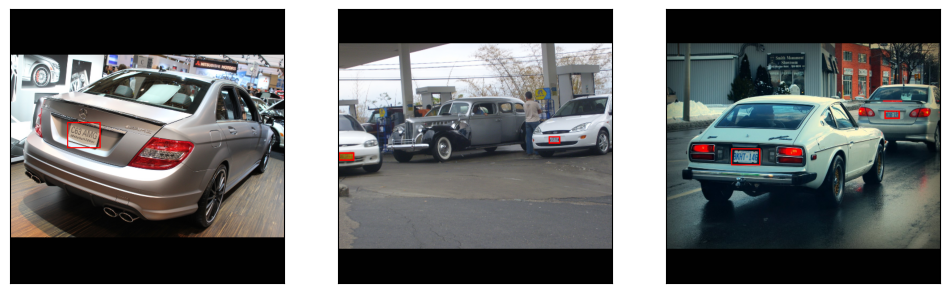

In [73]:
# Display images

im_list = [ ]
for i, im_path in enumerate(list(valid_path.rglob("*.jpg"))[:3]):

    # Read bounding boxes
    label_path = valid_path / r"Label" / f"{im_path.stem}.txt"
    bboxes = read_bboxes(label_path)
    bboxes =  torch.tensor(bboxes, dtype=torch.float)    
    
    # Read image and draw bounding boxes on it
    image = read_image(str(im_path))
    image = draw_bounding_boxes(image, bboxes, colors="red", width=5)
   
    # Resize and letterbox image
    image = image.permute(1, 2, 0).numpy()
    image = resize_and_letter_box(image, 480, 480)
    
    im_list.append(image)
    
show_images(im_list)

In [127]:
create_yolo(train_path, output_base_path=Path("train"))

100%|██████████| 5308/5308 [13:27<00:00,  6.57it/s]


In [128]:
create_yolo(valid_path, output_base_path=Path("valid"))

100%|██████████| 386/386 [01:05<00:00,  5.87it/s]


In [ ]:
%%writefile config.yaml

train: ../train 
val: ../valid

nc: 1  
names: ['plate'] 

#  <font style="color:green">2. Training [25 Points]</font> 

In [5]:
%cd yolov5
!python train.py --img 640 --batch 2 --epochs 5 --data ../config.yaml --weights ../yolov5s.pt --exist-ok
%cd ../

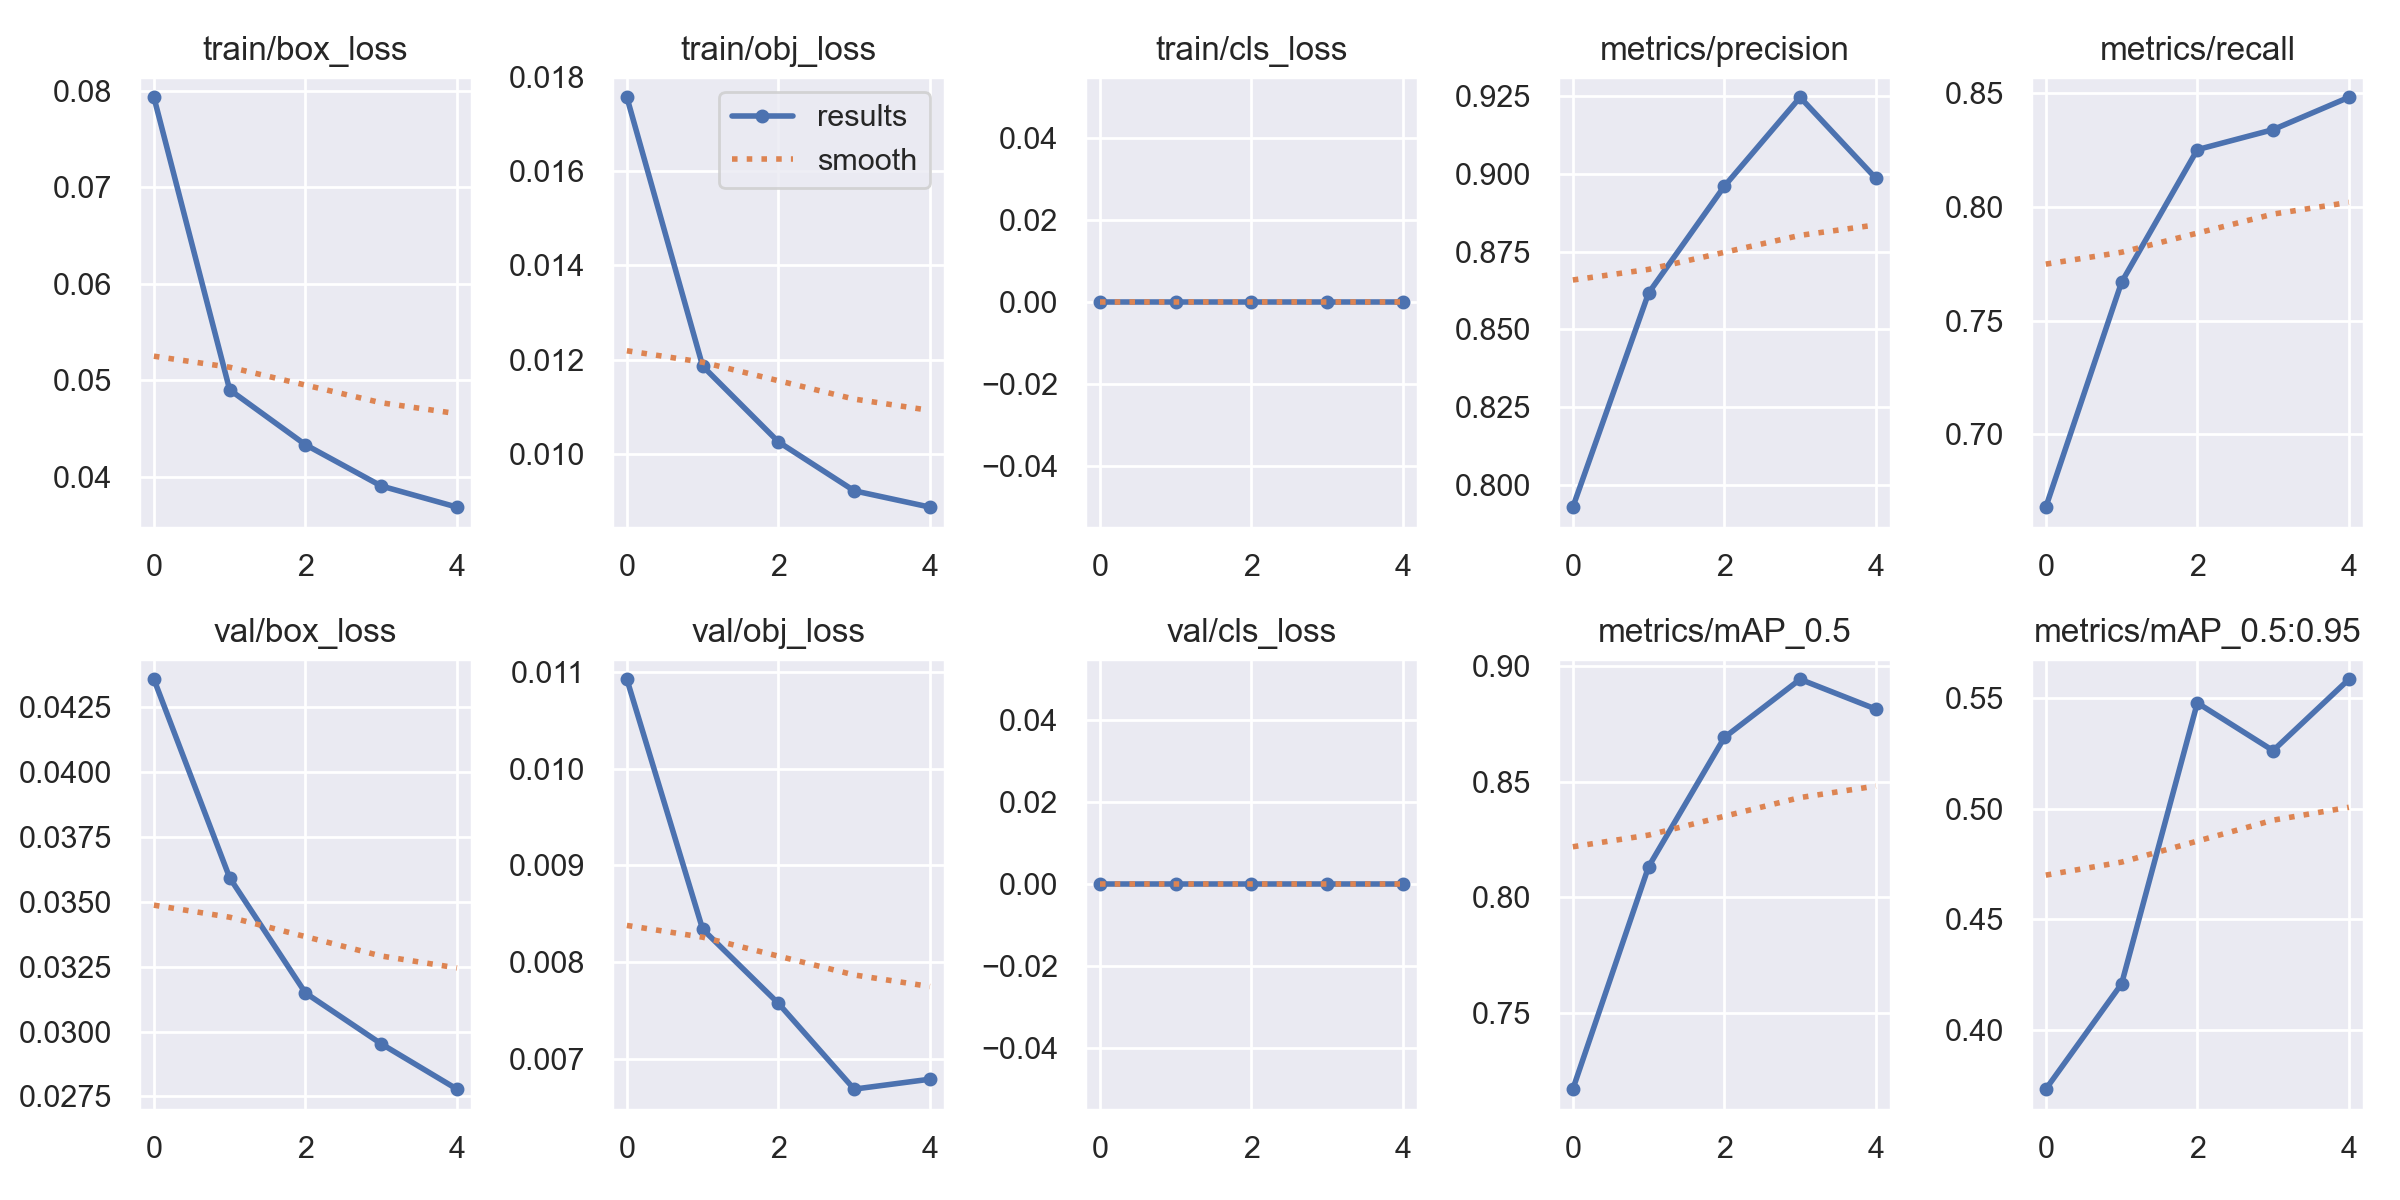

In [13]:
results = cv2.imread(r"yolov5\runs\train\exp5\results.png")
cv2_imshow(results)

#  <font style="color:green">3. Inference [15 Points]</font> 

In [10]:
model = torch.hub.load('yolov5', 'custom', path='yolov5/runs/train/exp5/weights/best.pt', source='local')

YOLOv5  v7.0-277-g703d37ef Python-3.11.6 torch-2.1.0 CUDA:0 (NVIDIA GeForce GTX 1050, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
Adding AutoShape... 


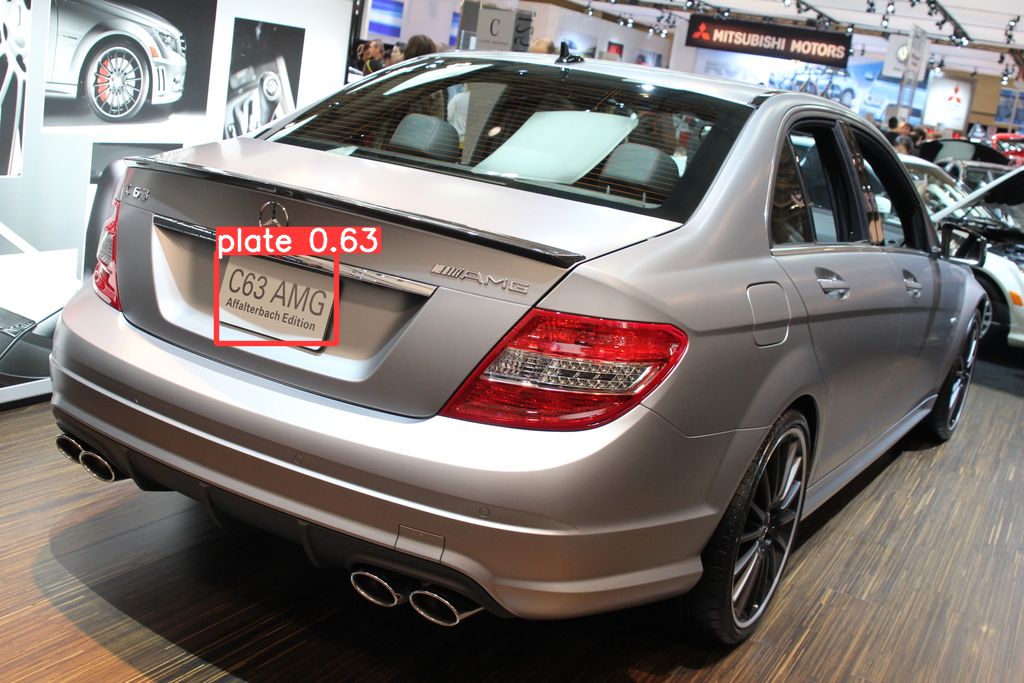

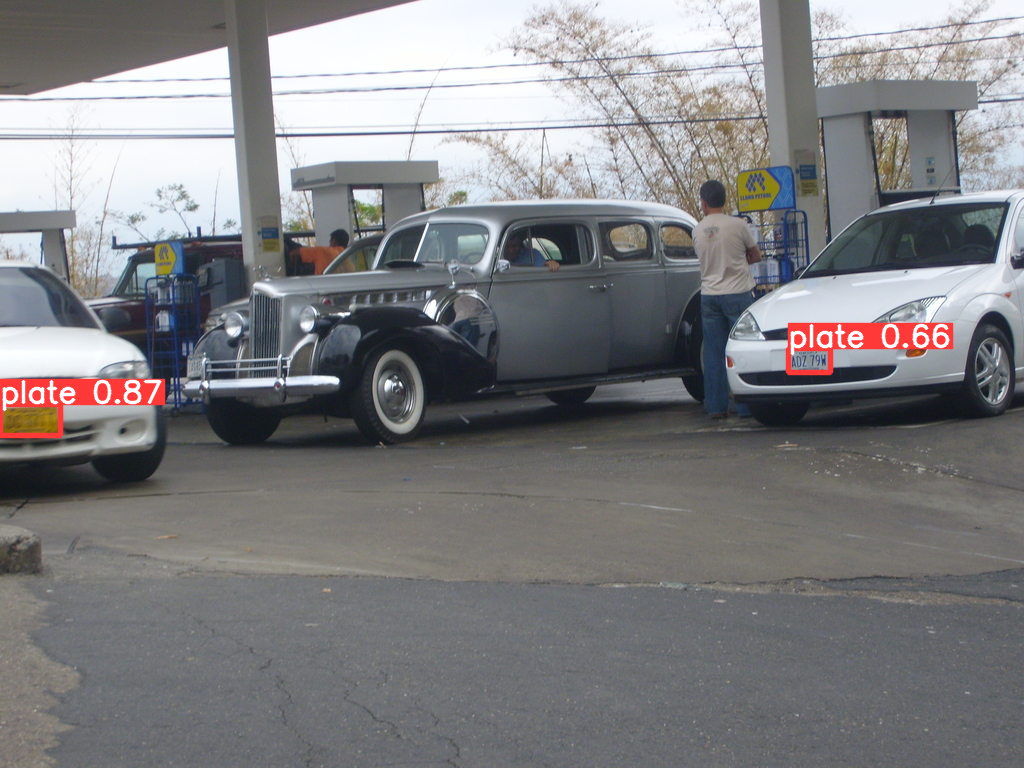

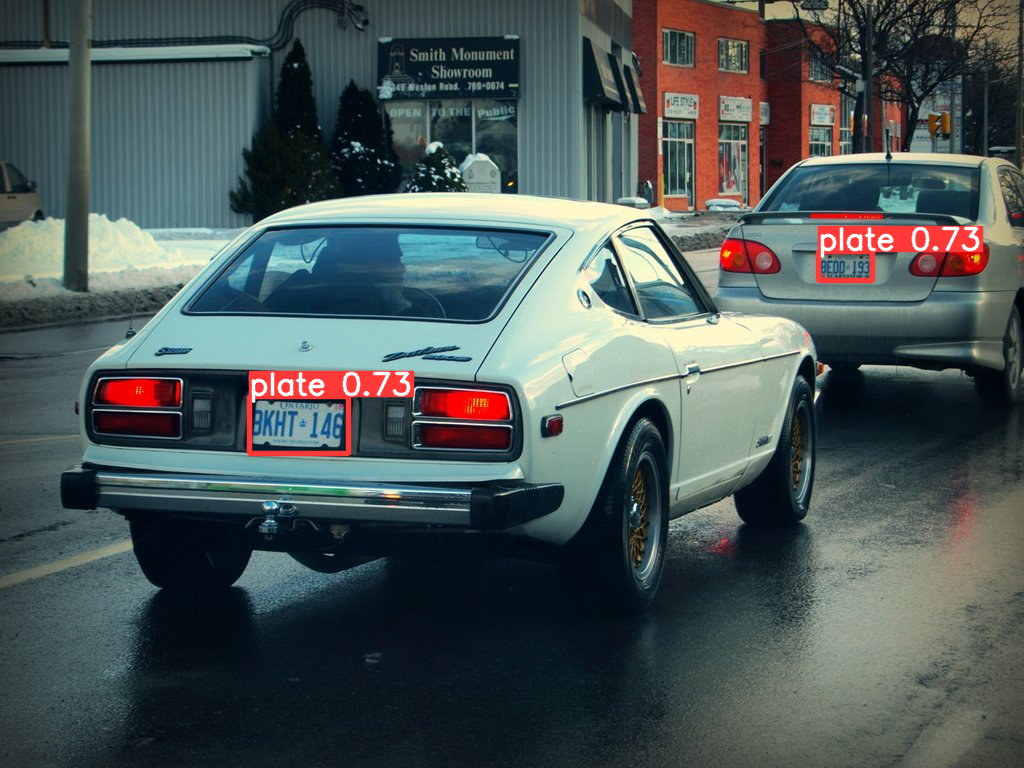

In [110]:
results = [ ]
for i, im_path in enumerate(list(valid_path.rglob("*.jpg"))[:3]):
    detections = model(im_path)
    detections.show()  # or .show(), .save(), .crop(), .pandas(), etc

#  <font style="color:green">4. COCO Detection Evaluation [25 Points]</font> 


In [4]:
!python yolov5/val.py --img 640 --data config.yaml --weights yolov5/runs/train/exp5/weights/best.pt

val: data=config.yaml, weights=['yolov5/runs/train/exp5/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=yolov5\runs\val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5  v7.0-277-g703d37ef Python-3.11.6 torch-2.1.0 CUDA:0 (NVIDIA GeForce GTX 1050, 4096MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs

val: Scanning F:\CURSOS\OPENCV_UNIVERSITY\DeepLearningWithPyTorch\opencv-dl-pytorch-week10\Project\valid\labels.cache... 386 images, 0 backgrounds, 0 corrupt: 100%|██████████| 386/386 [00:00<?, ?it/s]
val: Scanning F:\CURSOS\OPENCV_UNIVERSITY\DeepLearningWithPyTorch\opencv-dl-pytorch-week10\Project\valid\labels.cache... 386 images, 0 backgrounds, 0 corrupt: 100%|██████████| 386/386 [00:00<?, ?it/s]

                 Class     Images  Instance

# <font style="color:green">5. Run Inference on a Video [15 Points]</font>

In [24]:
def video_read_write(video_path):
    """
    video_path (str): path/to/video
    """

    video = cv2.VideoCapture(video_path)
    
    if not video.isOpened(): 
        print("Error opening video file")
        return
    
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    frames_per_second = video.get(cv2.CAP_PROP_FPS)   
    output_fname = '{}_out.mp4'.format(os.path.splitext(video_path)[0])
    
    output_file = cv2.VideoWriter(
        filename=output_fname,
        fourcc=cv2.VideoWriter_fourcc(*"MPEG"),
        fps=float(frames_per_second),
        frameSize=(width, height),
        isColor=True,
    )
    
    i = 0
    while video.isOpened():
        print(f"Processing frame {str(i).zfill(3)}", end='\r')
        ret, frame = video.read()
        if ret:
            detections = model(frame)
            render = detections.render()[0]
            output_file.write(render)
            i += 1
        else:
            print("Breaking")
            break
    
    print("Done. Writing video.")
    video.release()
    output_file.release()

In [25]:
video_read_write("project3-input-video.mp4")

Breakingng frame 131


https://youtu.be/Ba4ZWC8R2iE